In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader,random_split,TensorDataset # contains two main classes to store the data: Dataset and Dataloader
from torch import nn
import torch

In [4]:
import sys
# Append the directory of your module to Python's search path
sys.path.append('/mnt/home/jzang/frg/freq_frg/code')
from models import Autoencoder
from cost import train_epoch, test_epoch,get_output_and_error
from cPCA import CustomPCA

In [5]:
plt.rcParams.update({'font.size': 16})

In [6]:
filename = "/mnt/home/jzang/ceph/freq_frg/SIAM.KF.U3.0.T1.0.e0.0.h5"
with h5py.File(filename, 'r') as file:
    mesh_bosonic=np.array(file['vertex_total']['mesh_bosonic'])
    mesh_fermionic_1 = np.array(file['vertex_total']['mesh_fermionic_1'])
    mesh_fermionic_2 = np.array(file['vertex_total']['mesh_fermionic_2'])

In [7]:
part=14

In [8]:
### Set the random seed for reproducible results

torch.manual_seed(0)
np.random.seed(0)

# Generate indices and shuffle them
indices = np.arange(140)
np.random.shuffle(indices)

# Split indices for training and testing
train_indices = indices[:110]
test_indices =indices[110:]# np.arange(vertex_uddu_stacked.shape[0])# indices[110:]

In [9]:
filename = f"/mnt/home/jzang/ceph/freq_frg/store_data/vertex_total_uddu_part{part}.h5"
with h5py.File(filename, 'a') as file:
    vertex_uddu=np.array(file['vertex_uddu'])
    vertex_uddu_mean=np.array(file['vertex_uddu_mean'])
    table=np.array(file['parameters'])
    indice=np.array(file['indice'])
    
    

In [10]:
vertex_uddu=vertex_uddu.reshape(vertex_uddu.shape[0],-1)

In [11]:
vertex_uddu_mean=vertex_uddu_mean.reshape(201*101*101)

In [12]:
vertex_uddu.shape

(140, 2050401)

In [13]:
filename = f"/mnt/home/jzang/ceph/freq_frg/svd/train_test_split/svd_all_vertex_part{part}_50.h5"
with h5py.File(filename, 'r') as file:
    U_m=np.array(file['U'])
    S_m=np.array(file['S'])
    Vh_m=np.array(file['Vh'])
pca = CustomPCA(U_m, S_m, Vh_m)
del U_m, S_m, Vh_m    

In [14]:
# Optionally, print the explained variance ratio and its cumulative sum
print("Explained Variance Ratio (%):", pca.explained_variance_ratio_ )
print("Cumulative Explained Variance Ratio (%):", pca.cum_exp_var )



Explained Variance Ratio (%): [6.61499743e+01 1.87436194e+01 5.73402957e+00 2.37399443e+00
 1.70740270e+00 1.31280703e+00 9.93983718e-01 7.28767277e-01
 5.00200796e-01 3.27759141e-01 2.79961863e-01 2.10164586e-01
 1.82618663e-01 1.45837149e-01 1.07290496e-01 8.95872999e-02
 8.03692716e-02 5.94228535e-02 4.78651778e-02 4.52345664e-02
 3.54885016e-02 3.01287993e-02 2.54957536e-02 2.02651355e-02
 1.28988886e-02 1.04387849e-02 9.30062723e-03 6.33512480e-03
 5.47497758e-03 4.81814678e-03 4.05594807e-03 3.08289785e-03
 2.39037719e-03 1.96388577e-03 1.39570438e-03 1.21955909e-03
 1.00056984e-03 7.56503318e-04 5.69748347e-04 4.40881853e-04
 3.96141464e-04 2.78934071e-04 2.07339963e-04 1.68790900e-04
 1.53752224e-04 9.77369652e-05 8.81860230e-05 6.52623110e-05
 5.32058127e-05 4.30926536e-05 3.63976496e-05]
Cumulative Explained Variance Ratio (%): [ 66.14997432  84.89359375  90.62762332  93.00161775  94.70902045
  96.02182749  97.0158112   97.74457848  98.24477928  98.57253842
  98.85250028  99.

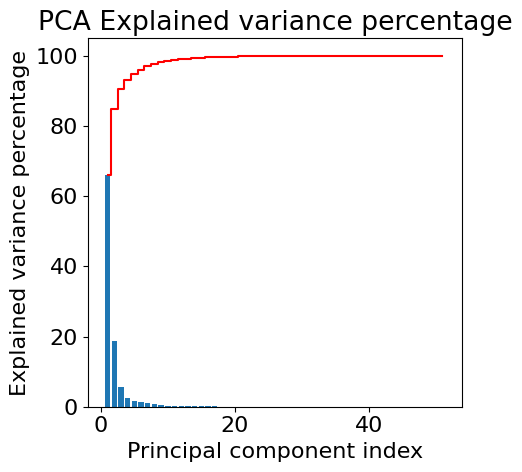

In [15]:

plt.figure(figsize=(5,5))
components=51#vertex_uddu.shape[0]
plt.bar(range(1, components+1), pca.explained_variance_ratio_ , align='center',
        label='Individual variance')

plt.step(range(1, components+1), pca.cum_exp_var, where='mid',
         label='Cumulative variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
# plt.legend(loc='right')
plt.title(f"PCA Explained variance percentage")#,T={T}")
plt.tight_layout()
#plt.savefig(f'fig/explain_variance.png',dpi=600, bbox_inches='tight')
plt.show()

In [16]:
original_shape=(140,201, 101, 101)

Transformed Data: (140, 51)


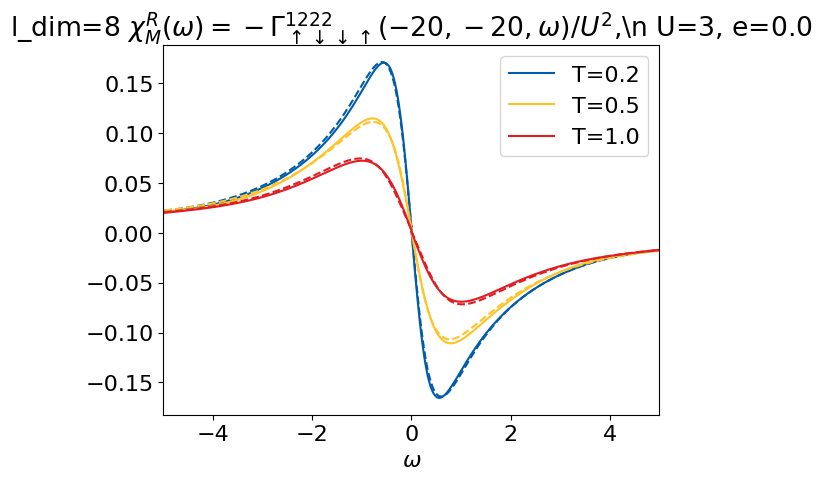

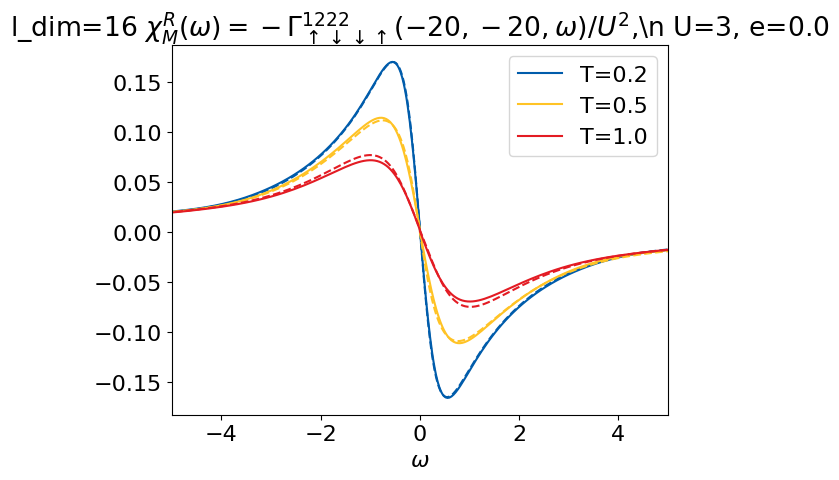

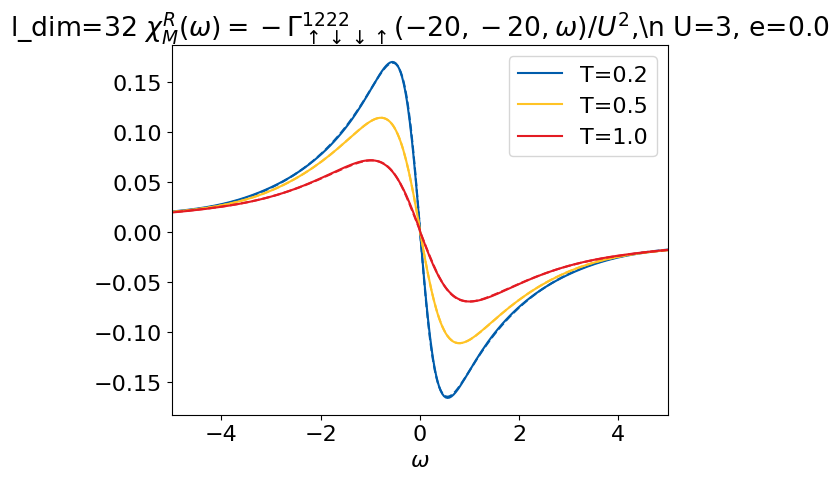

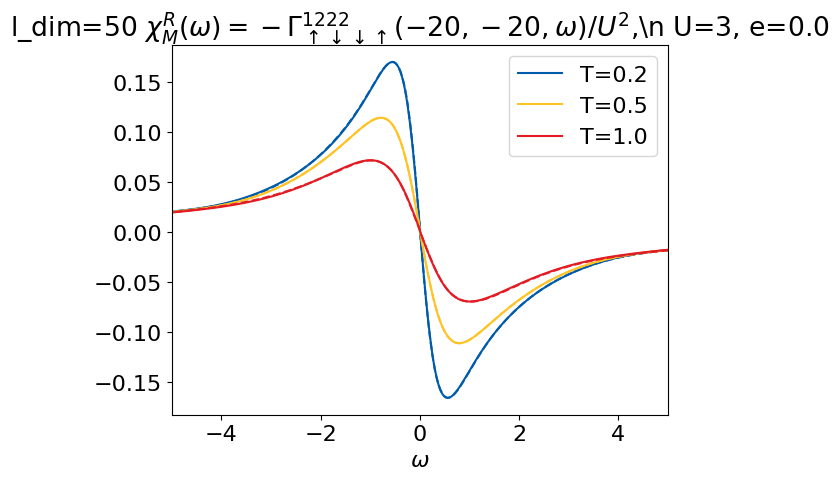

In [17]:
sus_original=(vertex_uddu+vertex_uddu_mean).reshape(original_shape)
X_transformed = pca.transform(vertex_uddu)
print("Transformed Data:", X_transformed.shape)
line_colors = [(0, 92/255, 171/255), (255/255, 195/255, 37/255), (227/255, 27/255, 35/255), "purple"]#,

errors_pca_list=[]
for latent_dim in [8,16,32,50]:
    j=0
    X_pca=X_transformed.copy()
    X_pca[:,latent_dim:]=0
    reconstructed_v = pca.inverse_transform(X_pca)    
    #calculate error
    squared_diff_magnitude = np.sum(np.abs(vertex_uddu - reconstructed_v)**2, axis=1)
    squared_orig_magnitude = np.sum(np.abs(vertex_uddu)**2, axis=1)
    error = np.sqrt(squared_diff_magnitude / squared_orig_magnitude)
    errors_pca_list.append(error)
    reconstructed_v =(reconstructed_v + vertex_uddu_mean).reshape(original_shape)
    
    
    for i, (U,T,e) in enumerate(table):
        if U==3.0 and e==0.0 and T in [0.5,1.0,0.2]:  
            plt.plot(mesh_bosonic,-sus_original[i,:, 0, 0].imag/U**2,label=f"T={T}",color=line_colors[j])
            plt.plot(mesh_bosonic,-reconstructed_v[i,:, 0, 0].imag/U**2,"--",color=line_colors[j])
            j+=1
    plt.xlim(-5,5)
    plt.legend()
    plt.xlabel(r"$\omega$")

    plt.title(f"l_dim={latent_dim} "+r"$\chi_{M}^{R}(\omega)=-\Gamma_{\uparrow \downarrow \downarrow \uparrow}^{1222}(-20,-20, \omega) / U^{2}$,\n U=3, e=0.0")
    plt.show()     
    


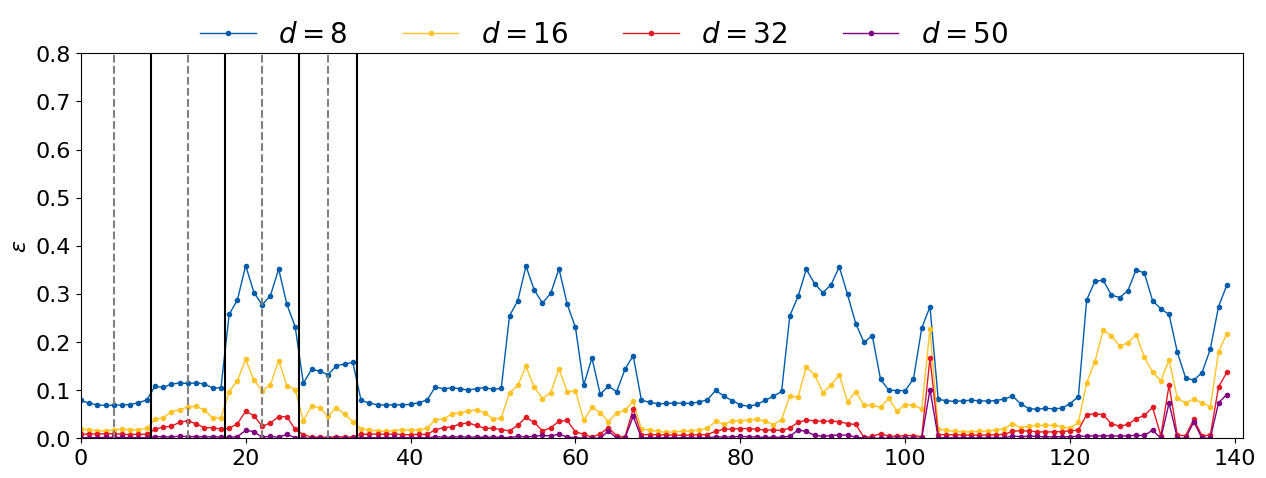

In [17]:

cmap_blue = plt.get_cmap('Blues')
cmap_red = plt.get_cmap('Reds')

line_colors = [(0, 92/255, 171/255), (255/255, 195/255, 37/255), (227/255, 27/255, 35/255), "purple"]#,
line_styles = ['dashed',  'dashdot','dotted','solid']#'dashed',
fig, ax = plt.subplots(figsize=(15,5))
# Plotting the errors for PCA
pca_latent_dims = [8,16,32,50]
for i, latent_dim in enumerate(pca_latent_dims):
    color=line_colors[i]
    ax.plot( errors_pca_list[i],".-", label=f'$d={latent_dim}$',  color=color,linewidth=1)
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=4, fontsize=20, frameon=False)
for x in [4,13,22,30]:
    plt.axvline(x=x, color="gray",linestyle="dashed")
for x in [8.5,17.5,26.5,33.5]:
    plt.axvline(x=x, color="black",linestyle="solid")

ax.set_ylim(0,0.8)
plt.xlim(0,141)
plt.show()


In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA available:', torch.cuda.get_device_name(0))
    print('CUDNN version:', torch.backends.cudnn.version())
    GPU_MEM = torch.cuda.get_device_properties(0).total_memory/(1024**2)
    print(f'Available GPU memory: {GPU_MEM:.2f} MB')
else:
    device = torch.device('cpu')
    print('CUDA not available')
    

CUDA available: NVIDIA A100-SXM4-80GB
CUDNN version: 8200
Available GPU memory: 81221.81 MB


In [19]:
vertex_uddu_real = vertex_uddu.real.astype(np.float32)
vertex_uddu_imag = vertex_uddu.imag.astype(np.float32)

vertex_uddu_stacked = np.stack([vertex_uddu_real, vertex_uddu_imag], axis=1).reshape(140,2,201,101,101)  # shape: (140, 2, 201, 101, 101)
del vertex_uddu_real, vertex_uddu_imag
vertex_uddu_stacked= torch.tensor(vertex_uddu_stacked)
couplings_total= torch.tensor(table)
batch_size = 32
dset_total = TensorDataset(vertex_uddu_stacked , couplings_total)
loader_total = DataLoader(dset_total, batch_size=batch_size)



3


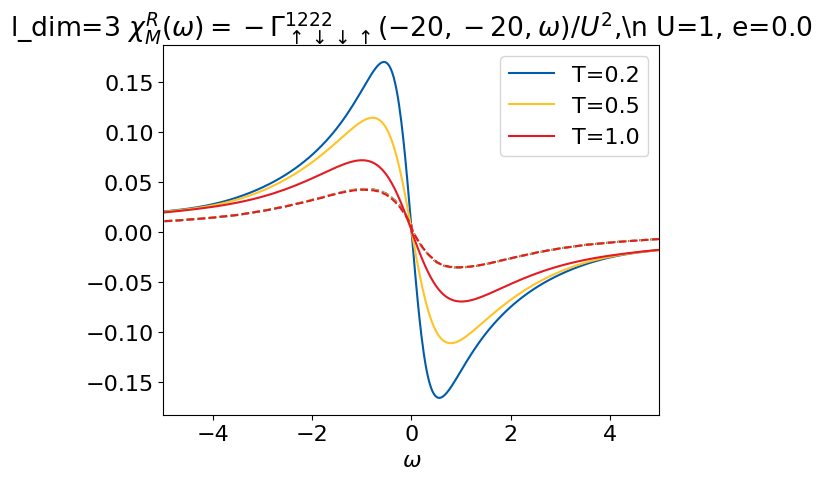

8


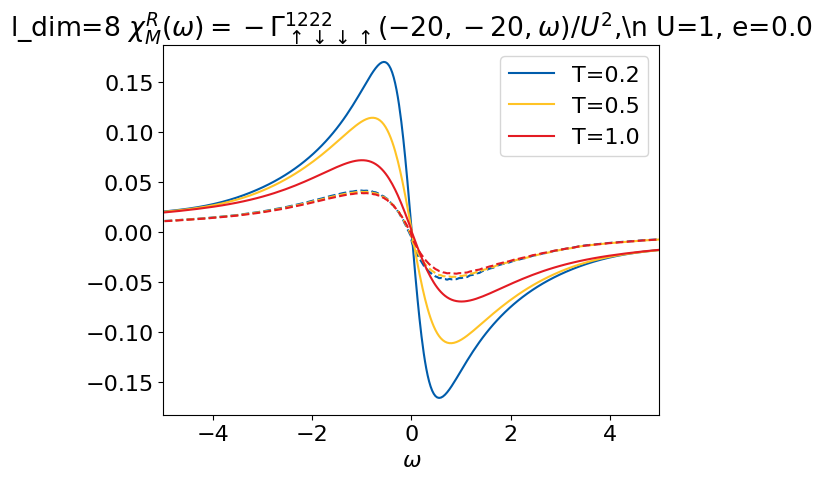

16


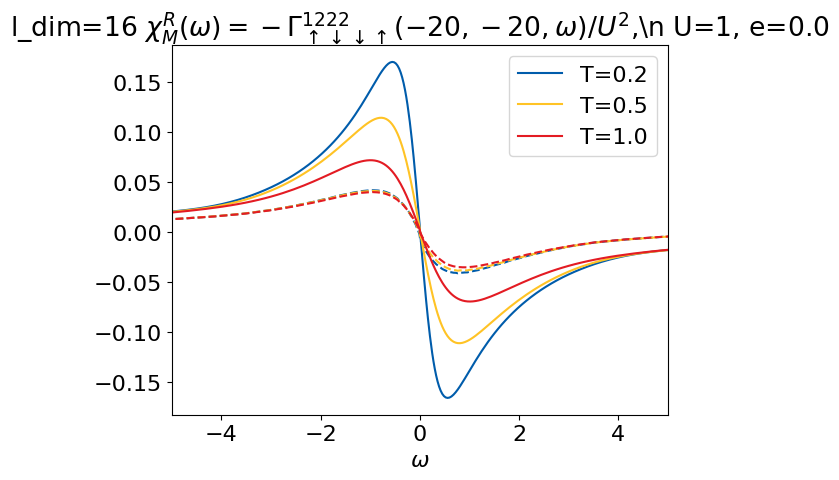

32


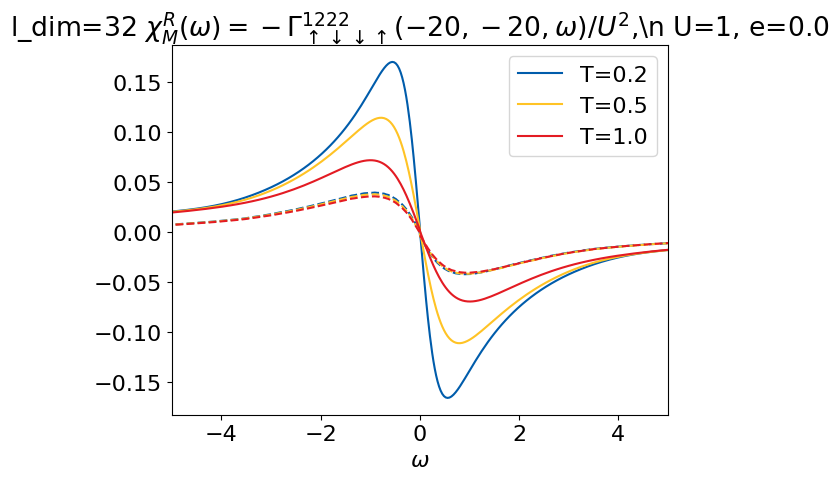

In [20]:



line_colors = [(0, 92/255, 171/255), (255/255, 195/255, 37/255), (227/255, 27/255, 35/255), "purple"]
hidden=32
lr = 1e-3
weight_decay = 0
ds= [3,8,16,32]
errors_ae_list=[]
reconstructed_v=np.zeros((140, 201, 101, 101),dtype='complex128')
for i, d in enumerate(ds):
    print(d)
    save_name = f"save/new_model/part={part}_hidden_dim={hidden}_lr={lr}_batch_size={batch_size}_Wdecay={weight_decay}_latentd={d}.pth"
    ae =Autoencoder(latent_dims=d,hidden_dim=hidden)
    ae.load_state_dict(torch.load(save_name))
    ae = ae.to(device) 
    errors,x_hats = get_output_and_error(ae,device,loader_total)
    errors_ae_list.append(errors)
    x_hats=np.array(x_hats)
    reconstructed_v.real=x_hats[:,0,:,:,:]
    reconstructed_v.imag=x_hats[:,1,:,:,:]    
    reconstructed_v =reconstructed_v + vertex_uddu_mean.reshape(201,101,101)
    j=0    
    for i, (U,T,e) in enumerate(table):
        if U==3.0 and e==0.0 and T in [0.5,1.0,0.2]:  
            plt.plot(mesh_bosonic,-sus_original[i,:, 0, 0].imag/U**2,label=f"T={T}",color=line_colors[j])
            plt.plot(mesh_bosonic,-reconstructed_v[i,:, 0, 0].imag/U**2,"--",color=line_colors[j])
            j+=1
    plt.xlim(-5,5)
    plt.legend()
    plt.xlabel(r"$\omega$")

    plt.title(f"l_dim={d} "+r"$\chi_{M}^{R}(\omega)=-\Gamma_{\uparrow \downarrow \downarrow \uparrow}^{1222}(-20,-20, \omega) / U^{2}$,\n U=1, e=0.0")
    plt.show()     
    



3 0.12888802052693257 0.35058076264964
8 0.12888802052693257 0.35058076264964
16 0.12888802052693257 0.35058076264964
32 0.12888802052693257 0.35058076264964


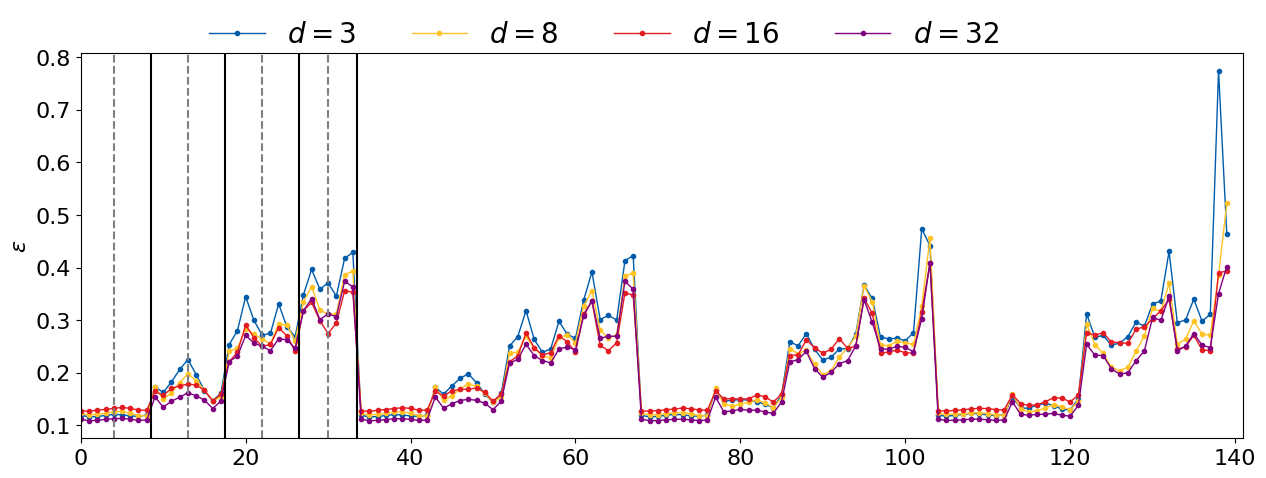

In [21]:

line_colors = [(0, 92/255, 171/255), (255/255, 195/255, 37/255), (227/255, 27/255, 35/255), "purple"]#,
line_styles = ['dashdot','dashdot','dashed','dotted','solid',"solid"]#
cmap_blue = plt.get_cmap('Blues')
cmap_red = plt.get_cmap('Reds')
fig, ax = plt.subplots(figsize=(15,5))
ds= [3,8,16,32]
for i, d in enumerate(ds):  
    color=line_colors[i]
    ax.plot(errors_ae_list[i], ".-", label=f'$d={d}$',  color=color,linewidth=1)#linestyle=line_styles[i]
    print(d,errors[82],errors[138])
ax.set_ylabel(r'$\epsilon$')
ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.15), ncol=4, fontsize=20, frameon=False)
for x in [4,13,22,30]:
    plt.axvline(x=x, color="gray",linestyle="dashed")
for x in [8.5,17.5,26.5,33.5]:
    plt.axvline(x=x, color="black",linestyle="solid")
plt.xlim(0,141)
plt.show()



In [23]:
vertex_original=(vertex_uddu+vertex_uddu_mean).reshape(original_shape)


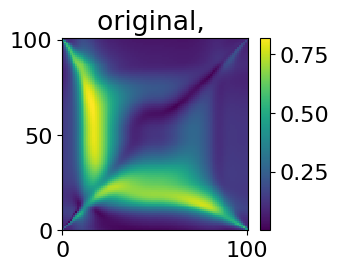

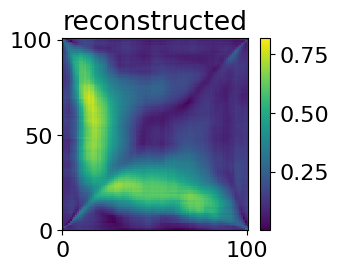

In [37]:
sample=20
k3=20
plt.figure(figsize=(3,2.5))
original=np.sqrt(vertex_original[sample,k3,:,:].real**2+vertex_original[sample,k3,:,:].imag**2)
max_v=np.max(original)
min_v=np.min(original)
plt.pcolormesh(original,vmax=max_v,vmin=min_v)
# plt.pcolormesh(X, Y,x_array[sample,0,k3,:,:],vmax=max_v,vmin=min_v)
# plt.xlabel(f"$\omega$")
# plt.ylabel(f"$\omega'$")
plt.title(f"original, ")
plt.colorbar()
plt.show()

plt.figure(figsize=(3,2.5))
original=np.sqrt(reconstructed_v[sample,k3,:,:].real**2+reconstructed_v[sample,k3,:,:].imag**2)
plt.pcolormesh(original,vmax=max_v,vmin=min_v)
# plt.pcolormesh(X, Y,x_array[sample,0,k3,:,:],vmax=max_v,vmin=min_v)
# plt.xlabel(f"$\omega$")
# plt.ylabel(f"$\omega'$")
plt.title(f"reconstructed")
plt.colorbar()
plt.show()